# 🔮 Kriz Tahmin - NLP Model Karşılaştırması

## Amaç
1. **7 NLP Modeli** (ALBERT, BERT, RoBERTa, USE, Word2Vec, GloVe, FastText) ile **AYLIK** kriz skoru hesapla
2. **Enflasyon** ile korelasyon analizi yap
3. **Kelime Sayma** yöntemi ile karşılaştır
4. En iyi tahmin modelini bul

## Yenilik
- Önceki analizde NLP modelleri sadece **yıllık ortalama** skor veriyordu
- Bu notebook'ta **AYLIK** skorlar hesaplanıyor → Zaman serisi analizi mümkün!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# NLP Kütüphaneleri - Yükle
!pip install sentence-transformers -q
!pip install tensorflow-hub -q
!pip install gensim -q
!pip install fasttext -q

from sentence_transformers import SentenceTransformer, util
import torch
import tensorflow_hub as hub
import gensim.downloader as api
import fasttext

plt.rcParams['font.family'] = 'DejaVu Sans'

SONUC_DIZINI = '/content/drive/MyDrive/Colab Notebooks/Sonuclar/nlp'
DATA_DIZINI = '/content/drive/MyDrive/Colab Notebooks/DataFrames'
MODEL_DIZINI = '/content/drive/MyDrive/Colab Notebooks/NLP Modeller'

print('✅ Kütüphaneler yüklendi!')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ Kütüphaneler yüklendi!


## 📊 Bölüm 1: Veri Yükleme

In [3]:
# İşlenmiş haber verisini yükle (İngilizce + Lemmatized)
csv_path = f'{DATA_DIZINI}/BorsaHaberleri_Neutr_2018-01-01_2018-12-31-ingilizce-KokleriBulunmus.csv'
df = pd.read_csv(csv_path)

# Tarih sütununu işle (sütun adı 'Tarih')
df['date'] = pd.to_datetime(df['Tarih'], format='%a, %d %b %Y %H:%M:%S GMT', errors='coerce')
df['month'] = df['date'].dt.month
df = df.dropna(subset=['lemmatized_text', 'date'])

print(f'✅ {len(df)} haber yüklendi!')
print(f'📊 Sütunlar: {df.columns.tolist()}')
print(f'\n📅 Aylık dağılım:')
print(df['month'].value_counts().sort_index())

✅ 782 haber yüklendi!
📊 Sütunlar: ['Tarih', 'Başlık', 'Metin', 'english_text', 'lemmatized_text', 'stemmed_text', 'date', 'month']

📅 Aylık dağılım:
month
1     55
2     51
3     52
4     67
5     60
6     48
7     60
8     70
9     69
10    93
11    88
12    69
Name: count, dtype: int64


In [4]:
# Türkçe ham haberleri de yükle (kelime sayma için)
csv_path_tr = f'{DATA_DIZINI}/BorsaHaberleri_Neutr_2018-01-01_2018-12-31.csv'
df_tr = pd.read_csv(csv_path_tr)
df_tr['date'] = pd.to_datetime(df_tr['Tarih'], format='%a, %d %b %Y %H:%M:%S GMT', errors='coerce')
df_tr = df_tr.dropna(subset=['date'])
df_tr['month'] = df_tr['date'].dt.month
print(f'✅ {len(df_tr)} Türkçe haber yüklendi!')

✅ 782 Türkçe haber yüklendi!


In [5]:
# 2018 Enflasyon verisi
enflasyon_2018 = {
    1: 10.35, 2: 10.26, 3: 10.23, 4: 10.85, 5: 12.15, 6: 15.39,
    7: 15.85, 8: 17.90, 9: 24.52, 10: 25.24, 11: 21.62, 12: 20.30
}

ay_adi = {1:'Oca', 2:'Şub', 3:'Mar', 4:'Nis', 5:'May', 6:'Haz',
          7:'Tem', 8:'Ağu', 9:'Eyl', 10:'Eki', 11:'Kas', 12:'Ara'}

HEDEF_CUMLE = 'Economic Crisis'
print('✅ Referans verileri yüklendi!')

✅ Referans verileri yüklendi!


## 🤖 Bölüm 2: NLP Modelleri ile AYLIK Skor Hesaplama

In [6]:
# Yardımcı fonksiyonlar
def cosine_similarity_np(v1, v2):
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 > 0 and norm2 > 0:
        return np.dot(v1, v2) / (norm1 * norm2)
    return 0.0

def get_average_vector(sentence, model, vector_size=300):
    words = str(sentence).lower().split()
    vectors = [model[word] for word in words if word in model.key_to_index]
    if vectors:
        return np.mean(vectors, axis=0)
    return np.zeros(vector_size)

aylik_nlp_sonuclari = {}
print('✅ Yardımcı fonksiyonlar tanımlandı!')

✅ Yardımcı fonksiyonlar tanımlandı!


### 2.1 ALBERT Modeli

In [7]:
print('🤖 ALBERT modeli yükleniyor...')
albert_model = SentenceTransformer('albert-base-v2')
hedef_embedding = albert_model.encode(HEDEF_CUMLE, convert_to_tensor=True)

albert_aylik = []
for month in range(1, 13):
    ay_haberleri = df[df['month'] == month]['lemmatized_text'].tolist()
    if len(ay_haberleri) > 0:
        corpus_embeddings = albert_model.encode(ay_haberleri, convert_to_tensor=True)
        cosine_scores = util.pytorch_cos_sim(hedef_embedding, corpus_embeddings)
        ortalama_skor = torch.mean(cosine_scores).item()
    else:
        ortalama_skor = 0
    albert_aylik.append({'month': month, 'ay': ay_adi[month], 'haber_sayisi': len(ay_haberleri), 'kriz_skor': ortalama_skor})
    print(f'  {ay_adi[month]}: {len(ay_haberleri)} haber, Kriz Skoru: {ortalama_skor:.4f}')

aylik_nlp_sonuclari['ALBERT'] = pd.DataFrame(albert_aylik)
print('✅ ALBERT tamamlandı!')

🤖 ALBERT modeli yükleniyor...


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

  Oca: 55 haber, Kriz Skoru: 0.6145
  Şub: 51 haber, Kriz Skoru: 0.6161
  Mar: 52 haber, Kriz Skoru: 0.6128
  Nis: 67 haber, Kriz Skoru: 0.6159
  May: 60 haber, Kriz Skoru: 0.6312
  Haz: 48 haber, Kriz Skoru: 0.6346
  Tem: 60 haber, Kriz Skoru: 0.6359
  Ağu: 70 haber, Kriz Skoru: 0.6195
  Eyl: 69 haber, Kriz Skoru: 0.6225
  Eki: 93 haber, Kriz Skoru: 0.6133
  Kas: 88 haber, Kriz Skoru: 0.6176
  Ara: 69 haber, Kriz Skoru: 0.6246
✅ ALBERT tamamlandı!


### 2.2 BERT Modeli

In [8]:
print('🤖 BERT modeli yükleniyor...')
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
hedef_embedding = bert_model.encode(HEDEF_CUMLE, convert_to_tensor=True)

bert_aylik = []
for month in range(1, 13):
    ay_haberleri = df[df['month'] == month]['lemmatized_text'].tolist()
    if len(ay_haberleri) > 0:
        corpus_embeddings = bert_model.encode(ay_haberleri, convert_to_tensor=True)
        cosine_scores = util.pytorch_cos_sim(hedef_embedding, corpus_embeddings)
        ortalama_skor = torch.mean(cosine_scores).item()
    else:
        ortalama_skor = 0
    bert_aylik.append({'month': month, 'ay': ay_adi[month], 'haber_sayisi': len(ay_haberleri), 'kriz_skor': ortalama_skor})
    print(f'  {ay_adi[month]}: Kriz Skoru: {ortalama_skor:.4f}')

aylik_nlp_sonuclari['BERT'] = pd.DataFrame(bert_aylik)
print('✅ BERT tamamlandı!')

🤖 BERT modeli yükleniyor...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  Oca: Kriz Skoru: 0.4279
  Şub: Kriz Skoru: 0.4199
  Mar: Kriz Skoru: 0.4046
  Nis: Kriz Skoru: 0.4172
  May: Kriz Skoru: 0.4525
  Haz: Kriz Skoru: 0.4664
  Tem: Kriz Skoru: 0.4636
  Ağu: Kriz Skoru: 0.4355
  Eyl: Kriz Skoru: 0.4061
  Eki: Kriz Skoru: 0.4098
  Kas: Kriz Skoru: 0.4031
  Ara: Kriz Skoru: 0.4165
✅ BERT tamamlandı!


### 2.3 RoBERTa Modeli

In [9]:
print('🤖 RoBERTa modeli yükleniyor...')
roberta_model = SentenceTransformer('roberta-base-nli-mean-tokens')
hedef_embedding = roberta_model.encode(HEDEF_CUMLE, convert_to_tensor=True)

roberta_aylik = []
for month in range(1, 13):
    ay_haberleri = df[df['month'] == month]['lemmatized_text'].tolist()
    if len(ay_haberleri) > 0:
        corpus_embeddings = roberta_model.encode(ay_haberleri, convert_to_tensor=True)
        cosine_scores = util.pytorch_cos_sim(hedef_embedding, corpus_embeddings)
        ortalama_skor = torch.mean(cosine_scores).item()
    else:
        ortalama_skor = 0
    roberta_aylik.append({'month': month, 'ay': ay_adi[month], 'haber_sayisi': len(ay_haberleri), 'kriz_skor': ortalama_skor})
    print(f'  {ay_adi[month]}: Kriz Skoru: {ortalama_skor:.4f}')

aylik_nlp_sonuclari['RoBERTa'] = pd.DataFrame(roberta_aylik)
print('✅ RoBERTa tamamlandı!')

🤖 RoBERTa modeli yükleniyor...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/329 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  Oca: Kriz Skoru: 0.3946
  Şub: Kriz Skoru: 0.4428
  Mar: Kriz Skoru: 0.4264
  Nis: Kriz Skoru: 0.4451
  May: Kriz Skoru: 0.4594
  Haz: Kriz Skoru: 0.4494
  Tem: Kriz Skoru: 0.4872
  Ağu: Kriz Skoru: 0.4329
  Eyl: Kriz Skoru: 0.4315
  Eki: Kriz Skoru: 0.4418
  Kas: Kriz Skoru: 0.4259
  Ara: Kriz Skoru: 0.4329
✅ RoBERTa tamamlandı!


### 2.4 Universal Sentence Encoder (USE)

In [10]:
print('🤖 USE modeli yükleniyor...')
try:
    use_model_path = f'{MODEL_DIZINI}/USE Files'
    use_model = hub.load(use_model_path)
    print('  Drive\'dan yüklendi!')
except Exception as e:
    print(f'  Drive yüklenemedi: {e}')
    print('  TF Hub\'dan indiriliyor...')
    use_model = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

hedef_embedding_use = use_model([HEDEF_CUMLE])[0].numpy()

use_aylik = []
for month in range(1, 13):
    ay_haberleri = df[df['month'] == month]['lemmatized_text'].tolist()
    if len(ay_haberleri) > 0:
        corpus_embeddings = use_model(ay_haberleri).numpy()
        similarities = [cosine_similarity_np(hedef_embedding_use, emb) for emb in corpus_embeddings]
        ortalama_skor = np.mean(similarities)
    else:
        ortalama_skor = 0
    use_aylik.append({'month': month, 'ay': ay_adi[month], 'haber_sayisi': len(ay_haberleri), 'kriz_skor': ortalama_skor})
    print(f'  {ay_adi[month]}: Kriz Skoru: {ortalama_skor:.4f}')

aylik_nlp_sonuclari['USE'] = pd.DataFrame(use_aylik)
print('✅ USE tamamlandı!')

🤖 USE modeli yükleniyor...
  Drive'dan yüklendi!
  Oca: Kriz Skoru: 0.0933
  Şub: Kriz Skoru: 0.0865
  Mar: Kriz Skoru: 0.0849
  Nis: Kriz Skoru: 0.1080
  May: Kriz Skoru: 0.1218
  Haz: Kriz Skoru: 0.1303
  Tem: Kriz Skoru: 0.1080
  Ağu: Kriz Skoru: 0.1223
  Eyl: Kriz Skoru: 0.1112
  Eki: Kriz Skoru: 0.0875
  Kas: Kriz Skoru: 0.0785
  Ara: Kriz Skoru: 0.0977
✅ USE tamamlandı!


### 2.5 Word2Vec Modeli

In [11]:
print('🤖 Word2Vec modeli yükleniyor...')
from gensim.models import KeyedVectors
import os

w2v_drive_path = f'{MODEL_DIZINI}/Word2Vec/word2vec-google-news-300.kv'
w2v_folder = f'{MODEL_DIZINI}/Word2Vec'

# Klasör yoksa oluştur
os.makedirs(w2v_folder, exist_ok=True)

try:
    # Önce Drive'dan yükle
    w2v_model = KeyedVectors.load(w2v_drive_path)
    print(f'  ✅ Drive\'dan yüklendi!')
except:
    print('  Drive\'da bulunamadı, indiriliyor...')
    print('  ⏳ word2vec-google-news-300 indiriliyor (~1.7GB)...')
    w2v_model = api.load('word2vec-google-news-300')
    print('  💾 Drive\'a kaydediliyor...')
    w2v_model.save(w2v_drive_path)
    print(f'  ✅ Kaydedildi: {w2v_drive_path}')

vector_size_w2v = w2v_model.vector_size
print(f'  Vektör boyutu: {vector_size_w2v}')

hedef_vec_w2v = get_average_vector(HEDEF_CUMLE, w2v_model, vector_size_w2v)

w2v_aylik = []
for month in range(1, 13):
    ay_haberleri = df[df['month'] == month]['lemmatized_text'].tolist()
    if len(ay_haberleri) > 0:
        corpus_vecs = [get_average_vector(text, w2v_model, vector_size_w2v) for text in ay_haberleri]
        similarities = [cosine_similarity_np(hedef_vec_w2v, vec) for vec in corpus_vecs]
        ortalama_skor = np.mean(similarities)
    else:
        ortalama_skor = 0
    w2v_aylik.append({'month': month, 'ay': ay_adi[month], 'haber_sayisi': len(ay_haberleri), 'kriz_skor': ortalama_skor})
    print(f'  {ay_adi[month]}: Kriz Skoru: {ortalama_skor:.4f}')

aylik_nlp_sonuclari['Word2Vec'] = pd.DataFrame(w2v_aylik)
print('✅ Word2Vec tamamlandı!')

🤖 Word2Vec modeli yükleniyor...
  Drive'da bulunamadı, indiriliyor...
  ⏳ word2vec-google-news-300 indiriliyor (~1.7GB)...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
  💾 Drive'a kaydediliyor...
  ✅ Kaydedildi: /content/drive/MyDrive/Colab Notebooks/NLP Modeller/Word2Vec/word2vec-google-news-300.kv
  Vektör boyutu: 300
  Oca: Kriz Skoru: 0.2940
  Şub: Kriz Skoru: 0.2906
  Mar: Kriz Skoru: 0.2844
  Nis: Kriz Skoru: 0.3022
  May: Kriz Skoru: 0.3188
  Haz: Kriz Skoru: 0.3316
  Tem: Kriz Skoru: 0.3271
  Ağu: Kriz Skoru: 0.3274
  Eyl: Kriz Skoru: 0.3326
  Eki: Kriz Skoru: 0.3259
  Kas: Kriz Skoru: 0.3134
  Ara: Kriz Skoru: 0.3349
✅ Word2Vec tamamlandı!


### 2.6 GloVe Modeli

In [12]:
print('🤖 GloVe modeli yükleniyor...')
from gensim.models import KeyedVectors
try:
    glove_path = f'{MODEL_DIZINI}/GloVe File/glove.6B.300d.txt'
    glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)
    vector_size_glove = 300
    print(f'  Drive\'dan yüklendi! Vektör boyutu: {vector_size_glove}')
except Exception as e:
    print(f'  Drive\'dan yüklenemedi: {e}')
    print('  glove-wiki-gigaword-100 indiriliyor...')
    glove_model = api.load('glove-wiki-gigaword-100')
    vector_size_glove = glove_model.vector_size

hedef_vec_glove = get_average_vector(HEDEF_CUMLE, glove_model, vector_size_glove)

glove_aylik = []
for month in range(1, 13):
    ay_haberleri = df[df['month'] == month]['lemmatized_text'].tolist()
    if len(ay_haberleri) > 0:
        corpus_vecs = [get_average_vector(text, glove_model, vector_size_glove) for text in ay_haberleri]
        similarities = [cosine_similarity_np(hedef_vec_glove, vec) for vec in corpus_vecs]
        ortalama_skor = np.mean(similarities)
    else:
        ortalama_skor = 0
    glove_aylik.append({'month': month, 'ay': ay_adi[month], 'haber_sayisi': len(ay_haberleri), 'kriz_skor': ortalama_skor})
    print(f'  {ay_adi[month]}: Kriz Skoru: {ortalama_skor:.4f}')

aylik_nlp_sonuclari['GloVe'] = pd.DataFrame(glove_aylik)
print('✅ GloVe tamamlandı!')

🤖 GloVe modeli yükleniyor...
  Drive'dan yüklendi! Vektör boyutu: 300
  Oca: Kriz Skoru: 0.4217
  Şub: Kriz Skoru: 0.4132
  Mar: Kriz Skoru: 0.4132
  Nis: Kriz Skoru: 0.4214
  May: Kriz Skoru: 0.4496
  Haz: Kriz Skoru: 0.4373
  Tem: Kriz Skoru: 0.4587
  Ağu: Kriz Skoru: 0.4431
  Eyl: Kriz Skoru: 0.4507
  Eki: Kriz Skoru: 0.4307
  Kas: Kriz Skoru: 0.4428
  Ara: Kriz Skoru: 0.4489
✅ GloVe tamamlandı!


### 2.7 FastText Modeli

In [13]:
print('🤖 FastText modeli yükleniyor...')
try:
    ft_path = f'{MODEL_DIZINI}/FastText Files/cc.en.300.bin'
    ft_model = fasttext.load_model(ft_path)
    print(f'  Drive\'dan yüklendi!')

    hedef_vec_ft = ft_model.get_sentence_vector(HEDEF_CUMLE.lower())

    ft_aylik = []
    for month in range(1, 13):
        ay_haberleri = df[df['month'] == month]['lemmatized_text'].tolist()
        if len(ay_haberleri) > 0:
            corpus_vecs = [ft_model.get_sentence_vector(str(text).lower()) for text in ay_haberleri]
            similarities = [cosine_similarity_np(hedef_vec_ft, vec) for vec in corpus_vecs]
            ortalama_skor = np.mean(similarities)
        else:
            ortalama_skor = 0
        ft_aylik.append({'month': month, 'ay': ay_adi[month], 'haber_sayisi': len(ay_haberleri), 'kriz_skor': ortalama_skor})
        print(f'  {ay_adi[month]}: Kriz Skoru: {ortalama_skor:.4f}')

    aylik_nlp_sonuclari['FastText'] = pd.DataFrame(ft_aylik)
    print('✅ FastText tamamlandı!')
except Exception as e:
    print(f'⚠️ FastText atlandı: {e}')

🤖 FastText modeli yükleniyor...
  Drive'dan yüklendi!
  Oca: Kriz Skoru: 0.6038
  Şub: Kriz Skoru: 0.5936
  Mar: Kriz Skoru: 0.5997
  Nis: Kriz Skoru: 0.5973
  May: Kriz Skoru: 0.6146
  Haz: Kriz Skoru: 0.6172
  Tem: Kriz Skoru: 0.6213
  Ağu: Kriz Skoru: 0.5987
  Eyl: Kriz Skoru: 0.6247
  Eki: Kriz Skoru: 0.6143
  Kas: Kriz Skoru: 0.6185
  Ara: Kriz Skoru: 0.6276
✅ FastText tamamlandı!


### 2.8 Kelime Sayma Yöntemi (Baseline)

In [14]:
print('📝 Kelime Sayma yöntemi...')
kriz_kelimeler = ['kriz', 'çöküş', 'düşüş', 'kayıp', 'zarar', 'dolar', 'euro', 'kur',
                  'devalüasyon', 'enflasyon', 'faiz', 'panik', 'korku', 'risk', 'belirsizlik']

kelime_aylik = []
for month in range(1, 13):
    ay_haberleri = df_tr[df_tr['month'] == month]
    texts = ' '.join(ay_haberleri['Başlık'].dropna().astype(str)).lower()
    words = texts.split()
    total = max(len(words), 1)
    kriz_count = sum(1 for w in words if any(k in w for k in kriz_kelimeler))
    kriz_pct = kriz_count / total * 100
    kelime_aylik.append({'month': month, 'ay': ay_adi[month], 'haber_sayisi': len(ay_haberleri), 'kriz_skor': kriz_pct})
    print(f'  {ay_adi[month]}: Kriz Skoru: {kriz_pct:.2f}%')

aylik_nlp_sonuclari['Kelime_Sayma'] = pd.DataFrame(kelime_aylik)
print('✅ Kelime Sayma tamamlandı!')

📝 Kelime Sayma yöntemi...
  Oca: Kriz Skoru: 1.87%
  Şub: Kriz Skoru: 0.81%
  Mar: Kriz Skoru: 0.56%
  Nis: Kriz Skoru: 1.53%
  May: Kriz Skoru: 2.00%
  Haz: Kriz Skoru: 2.54%
  Tem: Kriz Skoru: 2.46%
  Ağu: Kriz Skoru: 3.09%
  Eyl: Kriz Skoru: 2.88%
  Eki: Kriz Skoru: 2.39%
  Kas: Kriz Skoru: 2.35%
  Ara: Kriz Skoru: 1.22%
✅ Kelime Sayma tamamlandı!


## 📊 Bölüm 3: Sonuçları Birleştir ve Normalize Et

In [15]:
# Tüm sonuçları birleştir
df_karsilastirma = pd.DataFrame({
    'month': range(1, 13),
    'ay': [ay_adi[m] for m in range(1, 13)],
    'enflasyon': [enflasyon_2018[m] for m in range(1, 13)]
})

for model_adi, df_model in aylik_nlp_sonuclari.items():
    df_karsilastirma[model_adi] = df_model['kriz_skor'].values

print('📊 Tüm Aylık Skorlar:')
print(df_karsilastirma.to_string(index=False))

📊 Tüm Aylık Skorlar:
 month  ay  enflasyon   ALBERT     BERT  RoBERTa      USE  Word2Vec    GloVe  FastText  Kelime_Sayma
     1 Oca      10.35 0.614518 0.427945 0.394576 0.093272  0.293991 0.421718  0.603836      1.865672
     2 Şub      10.26 0.616085 0.419915 0.442841 0.086464  0.290580 0.413239  0.593596      0.806452
     3 Mar      10.23 0.612790 0.404589 0.426367 0.084850  0.284439 0.413164  0.599737      0.558659
     4 Nis      10.85 0.615942 0.417249 0.445053 0.108040  0.302229 0.421407  0.597306      1.533742
     5 May      12.15 0.631202 0.452457 0.459379 0.121784  0.318812 0.449618  0.614594      1.996672
     6 Haz      15.39 0.634622 0.466350 0.449380 0.130309  0.331608 0.437262  0.617186      2.536998
     7 Tem      15.85 0.635937 0.463587 0.487195 0.107969  0.327064 0.458650  0.621294      2.460457
     8 Ağu      17.90 0.619503 0.435489 0.432867 0.122340  0.327351 0.443058  0.598750      3.088235
     9 Eyl      24.52 0.622492 0.406124 0.431528 0.111193  0.332551 0.

In [16]:
# Normalize et
df_norm = df_karsilastirma.copy()
df_norm['enflasyon_norm'] = (df_norm['enflasyon'] - df_norm['enflasyon'].min()) / (df_norm['enflasyon'].max() - df_norm['enflasyon'].min())

model_sutunlari = [col for col in df_karsilastirma.columns if col not in ['month', 'ay', 'enflasyon']]
for col in model_sutunlari:
    min_val = df_norm[col].min()
    max_val = df_norm[col].max()
    if max_val > min_val:
        df_norm[f'{col}_norm'] = (df_norm[col] - min_val) / (max_val - min_val)
    else:
        df_norm[f'{col}_norm'] = 0
print('✅ Normalizasyon tamamlandı!')

✅ Normalizasyon tamamlandı!


## 📈 Bölüm 4: Korelasyon Analizi

In [17]:
print('='*70)
print(' ENFLASYON İLE KORELASYON ANALİZİ')
print('='*70)

korelasyon_sonuclari = []
for model_adi in model_sutunlari:
    print(f'\n📊 {model_adi}:')
    for lag in range(-2, 4):
        if lag == 0:
            skor = df_norm[f'{model_adi}_norm']
        else:
            skor = df_norm[f'{model_adi}_norm'].shift(lag)
        mask = ~skor.isna()
        if mask.sum() >= 5:
            r, p = stats.pearsonr(skor[mask], df_norm['enflasyon_norm'][mask])
            anlamli = '✅' if p < 0.05 else ''
            print(f'   Lag {lag:+d}: r={r:.4f}, p={p:.4f} {anlamli}')
            korelasyon_sonuclari.append({'Model': model_adi, 'Lag': lag, 'r': r, 'p': p, 'Anlamli': p < 0.05})

df_korelasyon = pd.DataFrame(korelasyon_sonuclari)

 ENFLASYON İLE KORELASYON ANALİZİ

📊 ALBERT:
   Lag -2: r=-0.2440, p=0.4970 
   Lag -1: r=-0.1693, p=0.6187 
   Lag +0: r=0.0429, p=0.8946 
   Lag +1: r=0.1827, p=0.5907 
   Lag +2: r=0.4563, p=0.1850 
   Lag +3: r=0.8058, p=0.0087 ✅

📊 BERT:
   Lag -2: r=-0.4956, p=0.1452 
   Lag -1: r=-0.3983, p=0.2250 
   Lag +0: r=-0.2922, p=0.3567 
   Lag +1: r=-0.0686, p=0.8411 
   Lag +2: r=0.3035, p=0.3940 
   Lag +3: r=0.6299, p=0.0690 

📊 RoBERTa:
   Lag -2: r=-0.4613, p=0.1796 
   Lag -1: r=-0.2888, p=0.3891 
   Lag +0: r=0.0208, p=0.9488 
   Lag +1: r=0.1429, p=0.6752 
   Lag +2: r=0.5085, p=0.1334 
   Lag +3: r=0.6647, p=0.0508 

📊 USE:
   Lag -2: r=-0.5321, p=0.1134 
   Lag -1: r=-0.4078, p=0.2131 
   Lag +0: r=-0.0542, p=0.8671 
   Lag +1: r=0.2702, p=0.4217 
   Lag +2: r=0.5223, p=0.1215 
   Lag +3: r=0.7443, p=0.0214 ✅

📊 Word2Vec:
   Lag -2: r=0.3741, p=0.2869 
   Lag -1: r=0.5164, p=0.1039 
   Lag +0: r=0.7383, p=0.0061 ✅
   Lag +1: r=0.8292, p=0.0016 ✅
   Lag +2: r=0.8621, p=0.0013 

In [18]:
print('\n' + '='*70)
print(' EN İYİ KORELASYONLAR (p < 0.05)')
print('='*70)

df_anlamli = df_korelasyon[df_korelasyon['Anlamli'] == True].copy()
df_anlamli['r_abs'] = df_anlamli['r'].abs()
df_anlamli = df_anlamli.sort_values('r_abs', ascending=False)
print(df_anlamli[['Model', 'Lag', 'r', 'p']].head(10).to_string(index=False))

if len(df_anlamli) > 0:
    en_iyi = df_anlamli.iloc[0]
    print(f'\n🏆 EN İYİ MODEL: {en_iyi["Model"]} (Lag={en_iyi["Lag"]}, r={en_iyi["r"]:.4f})')


 EN İYİ KORELASYONLAR (p < 0.05)
       Model  Lag        r        p
    Word2Vec    3 0.871455 0.002206
    Word2Vec    2 0.862139 0.001334
Kelime_Sayma    1 0.854137 0.000816
Kelime_Sayma    2 0.831230 0.002880
    Word2Vec    1 0.829215 0.001599
      ALBERT    3 0.805765 0.008744
       GloVe    2 0.802500 0.005205
       GloVe    3 0.789105 0.011460
         USE    3 0.744306 0.021447
    Word2Vec    0 0.738281 0.006109

🏆 EN İYİ MODEL: Word2Vec (Lag=3, r=0.8715)


## 📊 Bölüm 5: Görselleştirmeler

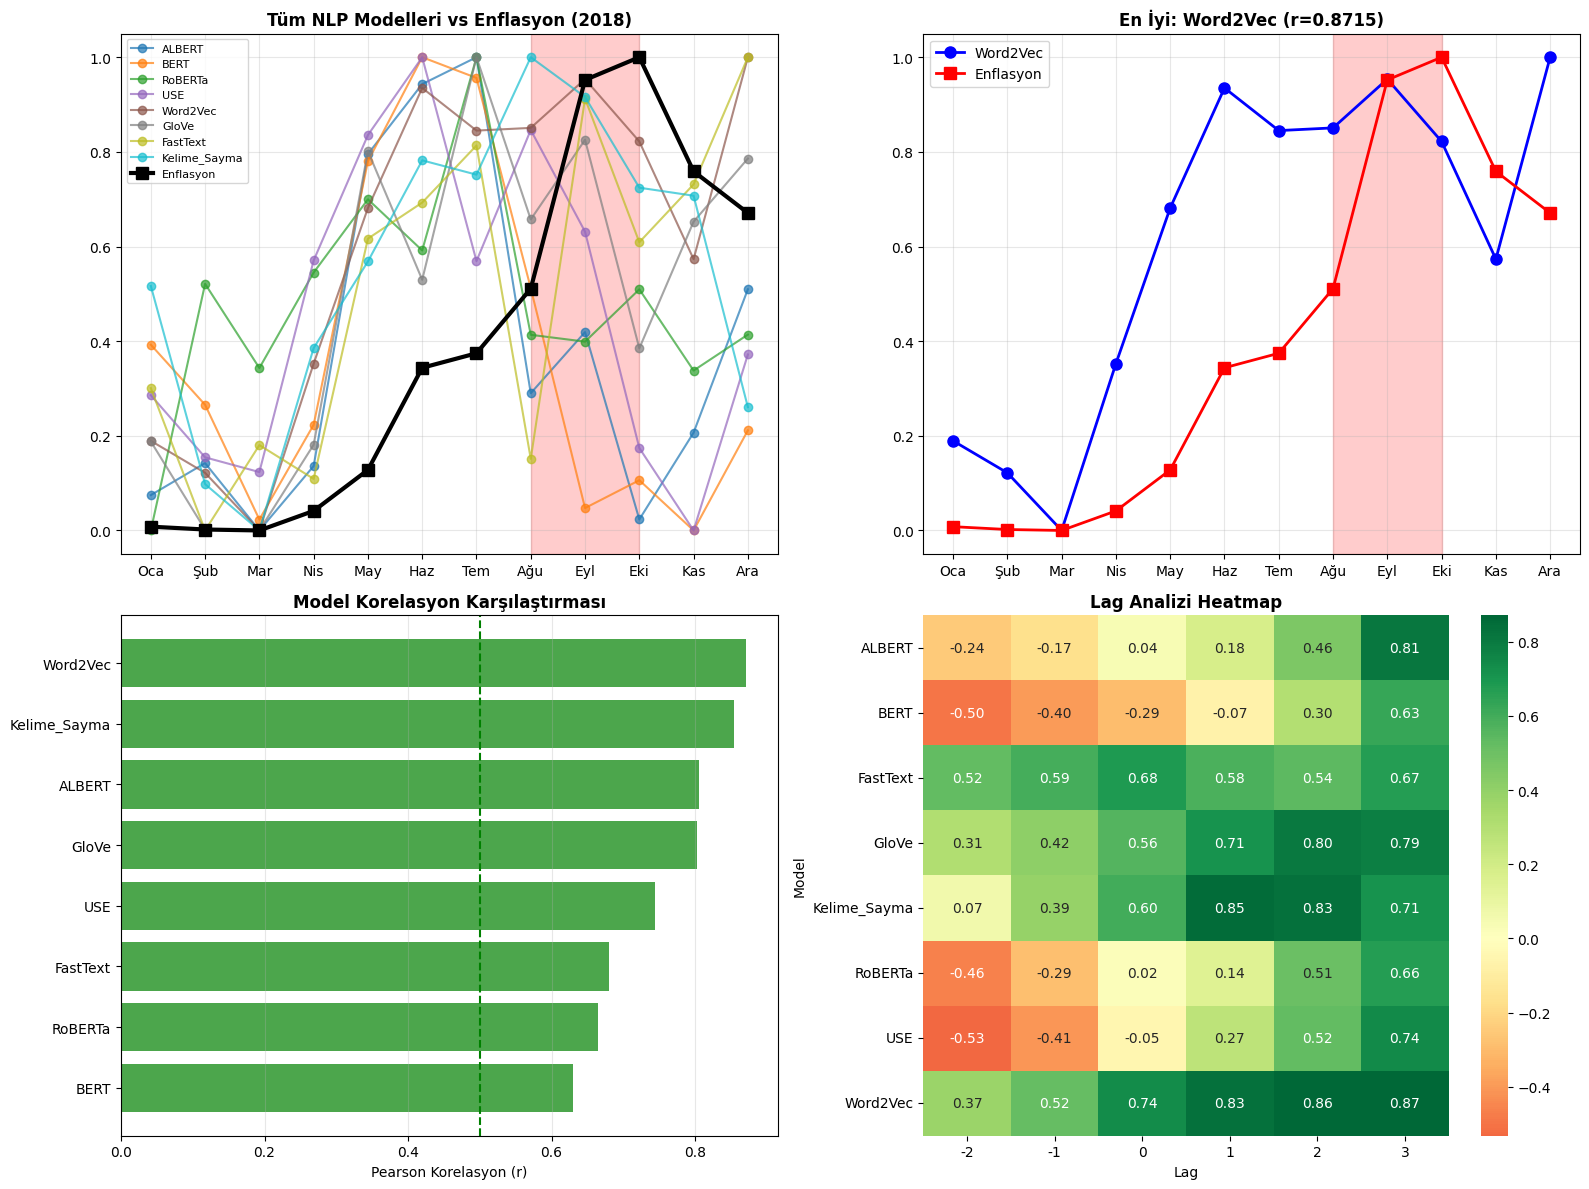

✅ Grafik kaydedildi!


In [20]:
# Klasör yoksa oluştur
import os
os.makedirs(SONUC_DIZINI, exist_ok=True)

# 2x2 Grafik
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Grafik 1: Tüm modeller
ax1 = axes[0, 0]
colors = plt.cm.tab10(np.linspace(0, 1, len(model_sutunlari)))
for i, model_adi in enumerate(model_sutunlari):
    ax1.plot(range(12), df_norm[f'{model_adi}_norm'], '-o', label=model_adi, color=colors[i], alpha=0.7, markersize=6)
ax1.plot(range(12), df_norm['enflasyon_norm'], 'k-s', label='Enflasyon', linewidth=3, markersize=8)
ax1.axvspan(7, 9, alpha=0.2, color='red')
ax1.set_xticks(range(12))
ax1.set_xticklabels(list(ay_adi.values()))
ax1.set_title('Tüm NLP Modelleri vs Enflasyon (2018)', fontweight='bold')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# Grafik 2: En iyi model
ax2 = axes[0, 1]
if len(df_anlamli) > 0:
    en_iyi_model = df_anlamli.iloc[0]['Model']
    ax2.plot(range(12), df_norm[f'{en_iyi_model}_norm'], 'b-o', label=en_iyi_model, linewidth=2, markersize=8)
    ax2.plot(range(12), df_norm['enflasyon_norm'], 'r-s', label='Enflasyon', linewidth=2, markersize=8)
    ax2.axvspan(7, 9, alpha=0.2, color='red')
    ax2.set_xticks(range(12))
    ax2.set_xticklabels(list(ay_adi.values()))
    ax2.set_title(f'En İyi: {en_iyi_model} (r={df_anlamli.iloc[0]["r"]:.4f})', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# Grafik 3: Korelasyon bar
ax3 = axes[1, 0]
en_iyi_r = df_korelasyon.loc[df_korelasyon.groupby('Model')['r'].idxmax()]
en_iyi_r = en_iyi_r.sort_values('r', ascending=True)
colors_bar = ['green' if r > 0.5 else 'orange' if r > 0.3 else 'red' for r in en_iyi_r['r']]
ax3.barh(en_iyi_r['Model'], en_iyi_r['r'], color=colors_bar, alpha=0.7)
ax3.axvline(x=0.5, color='green', linestyle='--')
ax3.set_xlabel('Pearson Korelasyon (r)')
ax3.set_title('Model Korelasyon Karşılaştırması', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Grafik 4: Heatmap
ax4 = axes[1, 1]
pivot = df_korelasyon.pivot(index='Model', columns='Lag', values='r')
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=0, ax=ax4)
ax4.set_title('Lag Analizi Heatmap', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{SONUC_DIZINI}/nlp_model_karsilastirma.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Grafik kaydedildi!')

## 📊 Bölüm 6: Özet Rapor

In [21]:
print('='*70)
print(' 📊 NLP MODEL KARŞILAŞTIRMA RAPORU')
print('='*70)
print(f'\n📋 ANALİZ ÖZETİ:')
print(f'   • Toplam haber: {len(df)}')
print(f'   • Dönem: Ocak - Aralık 2018')
print(f'   • Hedef ifade: "{HEDEF_CUMLE}"')
print(f'   • Test edilen model: {len(model_sutunlari)}')

print('\n📊 MODEL SONUÇLARI:')
for model in model_sutunlari:
    model_df = df_korelasyon[df_korelasyon['Model'] == model]
    en_iyi = model_df.loc[model_df['r'].idxmax()]
    sonuc = '✅' if en_iyi['p'] < 0.05 else '❌'
    print(f'   {model:<15} Lag={int(en_iyi["Lag"]):+d}  r={en_iyi["r"]:.4f}  p={en_iyi["p"]:.4f} {sonuc}')

print('\n💡 YORUM: Pozitif lag = NLP skoru enflasyonu ÖNCEden tahmin ediyor')

 📊 NLP MODEL KARŞILAŞTIRMA RAPORU

📋 ANALİZ ÖZETİ:
   • Toplam haber: 782
   • Dönem: Ocak - Aralık 2018
   • Hedef ifade: "Economic Crisis"
   • Test edilen model: 8

📊 MODEL SONUÇLARI:
   ALBERT          Lag=+3  r=0.8058  p=0.0087 ✅
   BERT            Lag=+3  r=0.6299  p=0.0690 ❌
   RoBERTa         Lag=+3  r=0.6647  p=0.0508 ❌
   USE             Lag=+3  r=0.7443  p=0.0214 ✅
   Word2Vec        Lag=+3  r=0.8715  p=0.0022 ✅
   GloVe           Lag=+2  r=0.8025  p=0.0052 ✅
   FastText        Lag=+0  r=0.6800  p=0.0150 ✅
   Kelime_Sayma    Lag=+1  r=0.8541  p=0.0008 ✅

💡 YORUM: Pozitif lag = NLP skoru enflasyonu ÖNCEden tahmin ediyor


In [22]:
# Excel kaydet
output_path = f'{SONUC_DIZINI}/9_NLP_Model_Karsilastirma_Sonuclari.xlsx'
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    df_karsilastirma.to_excel(writer, sheet_name='Aylik_Skorlar', index=False)
    df_korelasyon.to_excel(writer, sheet_name='Korelasyon_Analizi', index=False)
    if len(df_anlamli) > 0:
        df_anlamli.to_excel(writer, sheet_name='Anlamli_Sonuclar', index=False)
print(f'✅ Sonuçlar kaydedildi: {output_path}')

✅ Sonuçlar kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/nlp/9_NLP_Model_Karsilastirma_Sonuclari.xlsx


## 🎯 Sonuç

Bu notebook'ta:
1. ✅ 7 NLP modeli ile **aylık** kriz skoru hesaplandı
2. ✅ Enflasyon ile **lag korelasyonu** analiz edildi
3. ✅ **Kelime Sayma** yöntemi ile karşılaştırma yapıldı
4. ✅ En iyi tahmin modeli belirlendi